Let the RK45 solver decide how many points we should have and then, evaluate the solution

In [1]:
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, lstsq, norm
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model

In [2]:
#some most useful functions for data generations are now in scripts/mechanisms.py 
import sys
sys.path.insert(1, 'scripts/')
import scripts.mechanisms as mechanisms
import scripts.ls_solvers as solvers

In [3]:
plt.style.use('default')
#plt.rcParams["figure.figsize"] = (15,10)
#plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams.update({'font.size': 19})

In [4]:
constants = [1, 1, 1, 0]

In [5]:
k1, k_1, k2, k_2 = constants
W0 = np.array([[0, 0, 0, k_1, 0, -k1, 0,    0, 0, 0,  0,    0, 0, 0  ],
               [0, 0, 0, k2,      0, 0,   -k_2, 0, 0, 0,  0,    0, 0, 0 ],
               [0, 0, 0, k2+k_1,  0, -k1, -k_2, 0, 0, 0, 0,    0, 0, 0  ],
               [0, 0, 0, -k2-k_1, 0,  k1,  k_2, 0, 0, 0, 0,    0, 0, 0  ]])
W0.shape

(4, 14)

In [6]:
#initial values
U0 = np.array([1.0, 0.0, 0.1, 0.0])
# U0 = np.vstack((U0, [1.0, 0.0, 0.15, 0.0]))
# U0 = np.vstack((U0, [1.0, 0.0, 0.05, 0.0]))

In [7]:
#U0.shape

In [8]:
# if we have only one initial condition
U0 = U0.reshape((1,4))

In [9]:
integration = 'RK45'
#differentiation = 'spline'
differentiation = 'spline'

In [10]:
rtol = 1e-6

In [11]:
# increase time 
X, T, Y = mechanisms.find_solutions(U0, constants, 'A1r', differentiation, 100, rtol, integration) # checked fine

RK45


In [12]:
X.shape

(87, 4)

No handles with labels found to put in legend.


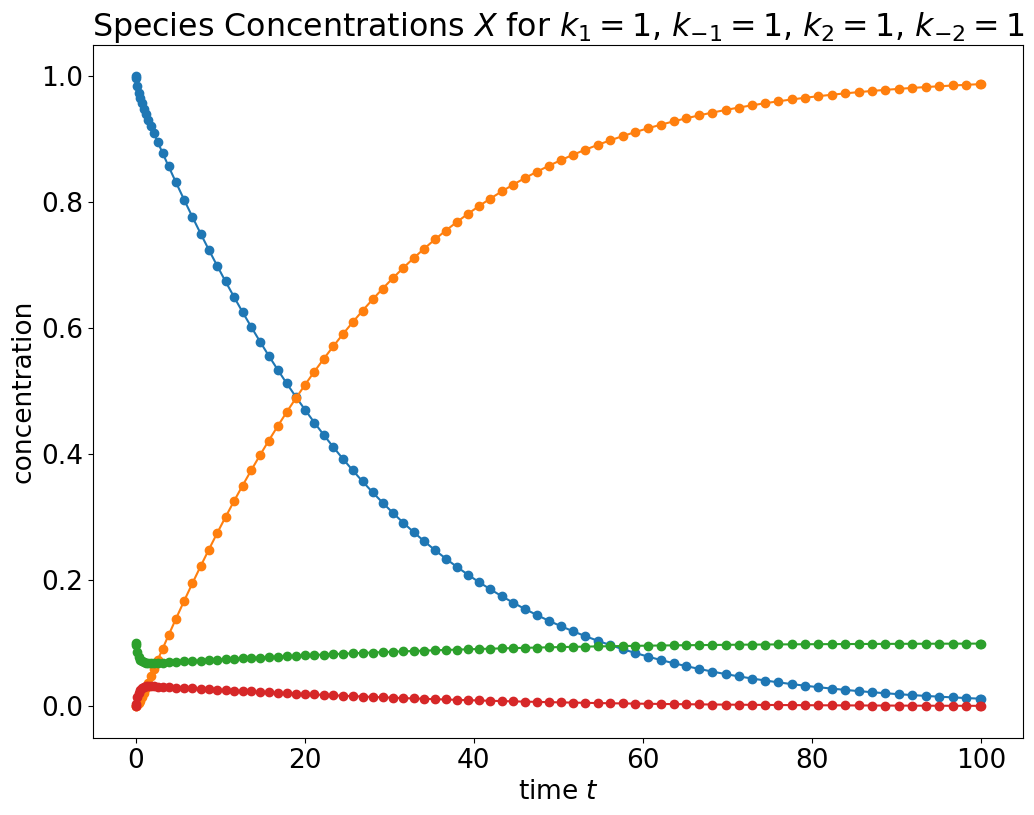

In [13]:
mechanisms.plot_concentrations(T, X, 'A1r')
plt.title('Species Concentrations $X$ for $k_1 = 1$, $k_{-1} = 1$, $k_2 = 1$, $k_{-2} = 1$')
plt.legend().set_visible(False)
plt.savefig('demo.png', transparent=True)

In [17]:
Y_gt = mechanisms.ode(T, X.T, constants, 'A1r').T

<function matplotlib.pyplot.show(*args, **kw)>

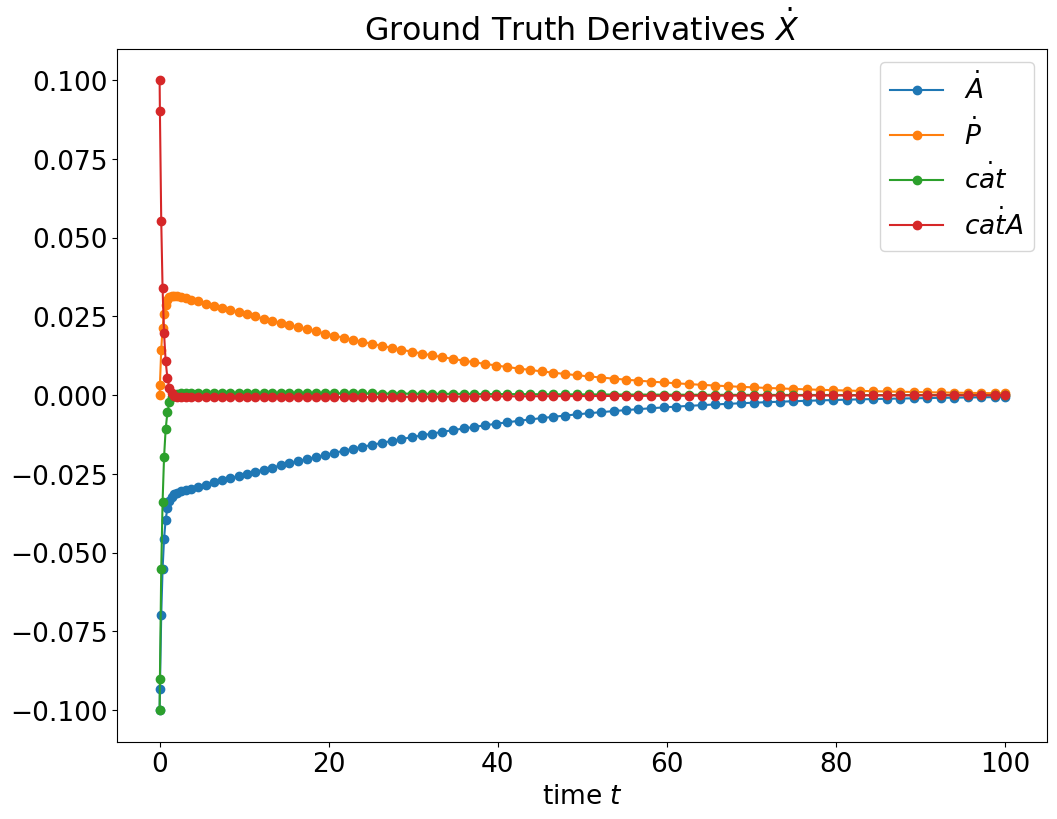

In [18]:
mechanisms.plot_derivatives(T, Y_gt, 'A1r')
plt.title('Ground Truth Derivatives $\dot{X}$')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

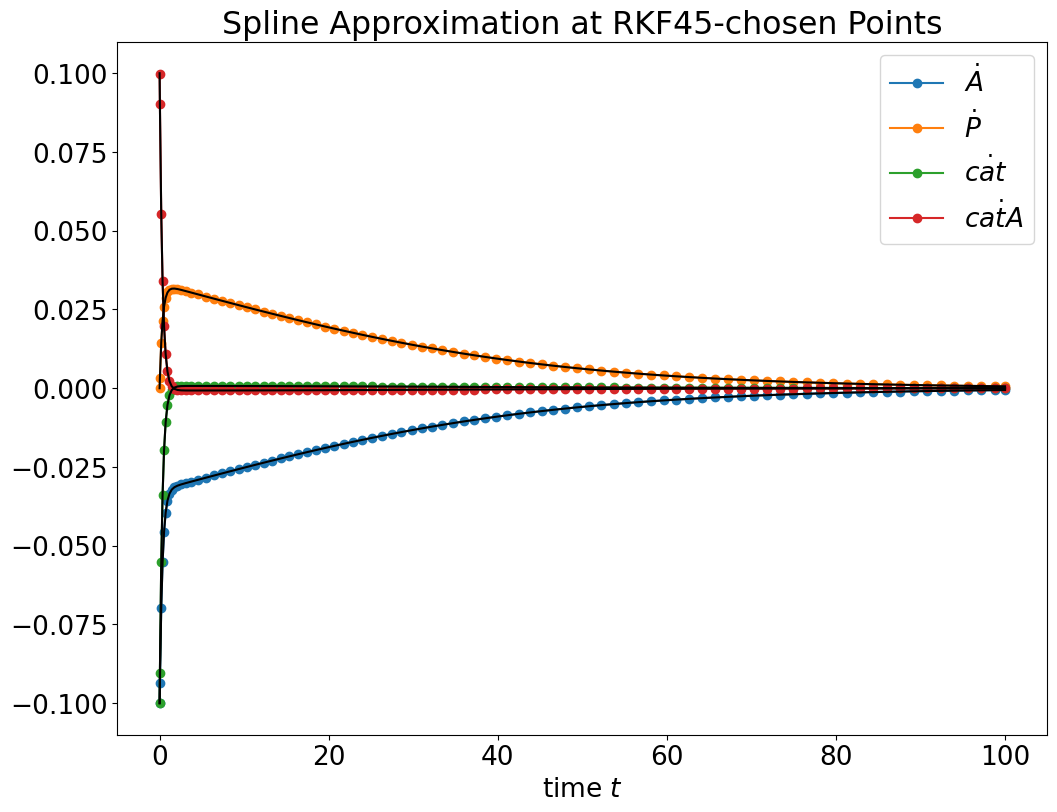

In [19]:
mechanisms.plot_derivatives(T, Y, 'A1r')
plt.plot(T, Y_gt, "-k")
plt.title('Spline Approximation at RKF45-chosen Points')
plt.show

In [20]:
mechanisms.get_residual(Y, Y_gt)

absolute residual 0.0002723289224105873
relative residual 0.0007818405762923797


(0.0002723289224105873, 0.0007818405762923797)

# PySINDy


In [31]:
X_tilde, labels = mechanisms.get_features(X, 'A1r', square=True)

added squared terms
X_tilde features matrix shape:  (87, 14)
labels:  ['A', 'P', 'cat', 'catA', 'P*A', 'cat*A', 'cat*P', 'catA*A', 'catA*P', 'catA*cat', 'A*A', 'P*P', 'cat*cat', 'catA*catA']


In [32]:
import pysindy as ps

In [33]:
def make_library(mechType):
    if mechType == 'A1r':
        feature_names = ['A', 'P', 'cat', 'catA']
    elif mechType == 'A1ra':
        feature_names = ['A', 'P', 'cat', 'catact', 'catactA']
    elif mechType == 'A2r':
        feature_names = ['A', 'P', 'cat', 'catA', 'B']
    library_functions = [
        lambda x : x,
        lambda x : x * x, 
        lambda x,y : x*y
    ]
    library_function_names = [
        lambda x : x ,
        lambda x :  x + '*' + x,
        lambda x,y : x + '*' + y 
    ]
    custom_library = ps.CustomLibrary(
         library_functions=library_functions, function_names=library_function_names,  
    )
    
    return [custom_library, feature_names]

In [34]:
opt = ps.STLSQ(threshold = 0.008, alpha=0.05) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()

(A)' = 0.905 catA + -0.050 A*A + -0.045 A*P + -0.502 A*cat + 0.547 A*catA
(P)' = 0.009 A + 0.956 catA + -0.007 A*A + -0.005 A*P + -0.019 A*cat + 0.020 A*catA
(cat)' = 0.020 A + -0.770 cat + 2.944 catA + -0.098 A*A + 7.702 cat*cat + -0.107 A*P + -0.223 A*cat + 0.225 A*catA
(catA)' = -0.020 A + 0.770 cat + -2.944 catA + 0.098 A*A + -7.702 cat*cat + 0.107 A*P + 0.223 A*cat + -0.225 A*catA


In [35]:
W_sindy = model_custom.coefficients()

In [36]:
mechanisms.print_equation(labels, W_sindy, rtol)

+0.00[cat]+0.90[catA]-0.05[P*A]-0.05[catA*P]-0.50[catA*cat]+0.55[A*A]
______
+0.01[A]+0.00[cat]+0.96[catA]-0.01[P*A]-0.00[catA*P]-0.02[catA*cat]+0.02[A*A]
______
+0.02[A]-0.77[cat]+2.94[catA]-0.10[P*A]+7.70[cat*P]-0.11[catA*P]-0.22[catA*cat]+0.23[A*A]
______
-0.02[A]+0.77[cat]-2.94[catA]+0.10[P*A]-7.70[cat*P]+0.11[catA*P]+0.22[catA*cat]-0.23[A*A]
______
sparsity: 29


29

In [37]:
W_sindy_arr = []
lambdas = np.linspace(0, 0.05, 100)
W_ridge_arr = []
for lambd in lambdas: 
    opt = ps.STLSQ(threshold = lambd, alpha=0.05) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.031313131313131314) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.031818181818181815) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.03232323232323232) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.03282828282828283) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pys

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.04494949494949495) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/py

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ Equation using SINDy')

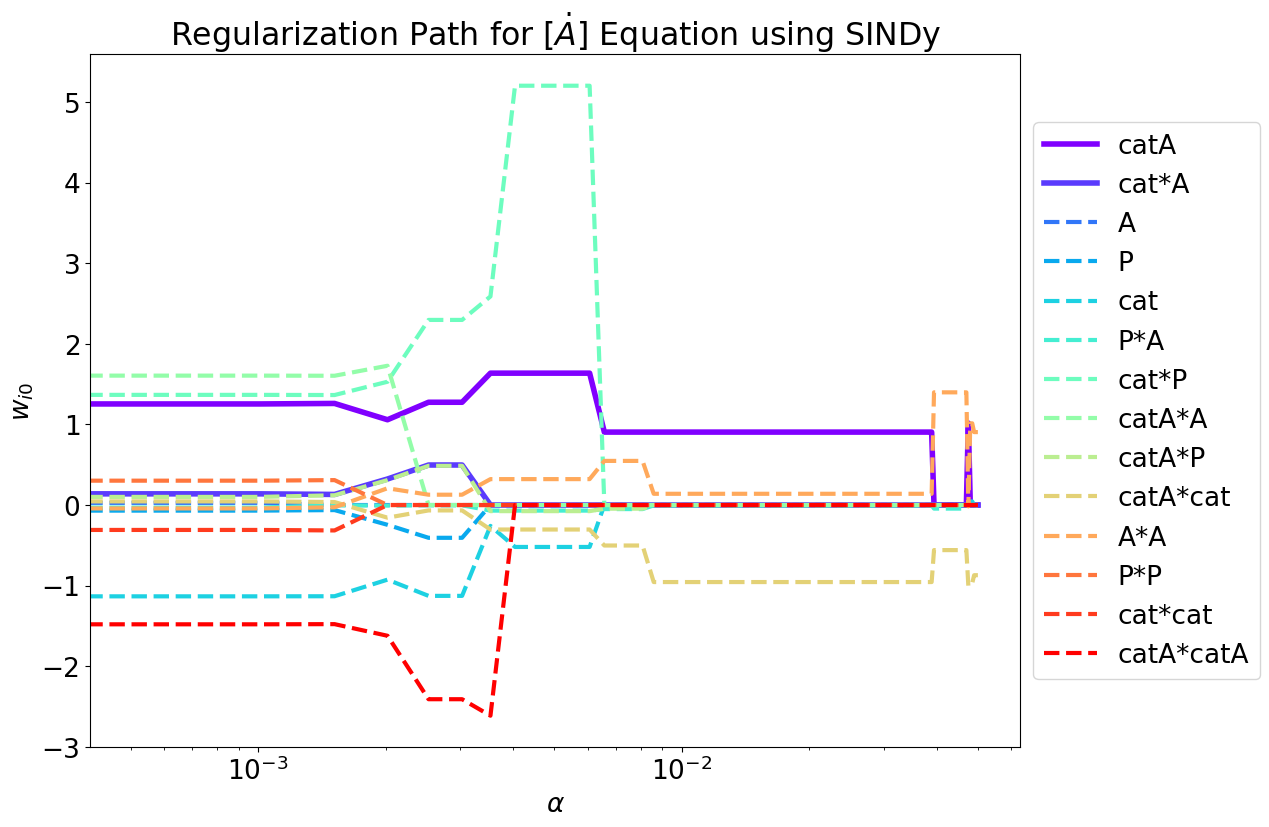

In [38]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]$ Equation using SINDy")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ Equation using SINDy')

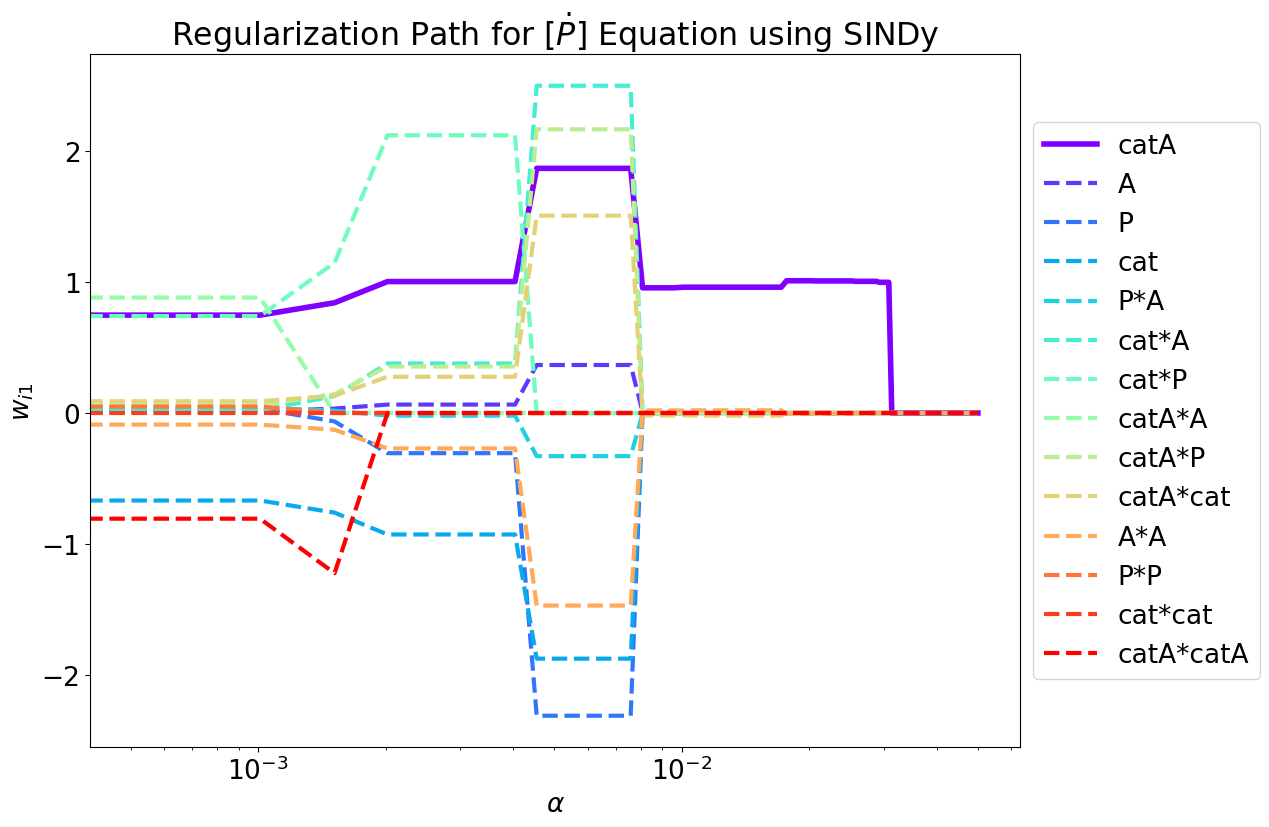

In [39]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]$ Equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ Equation using SINDy')

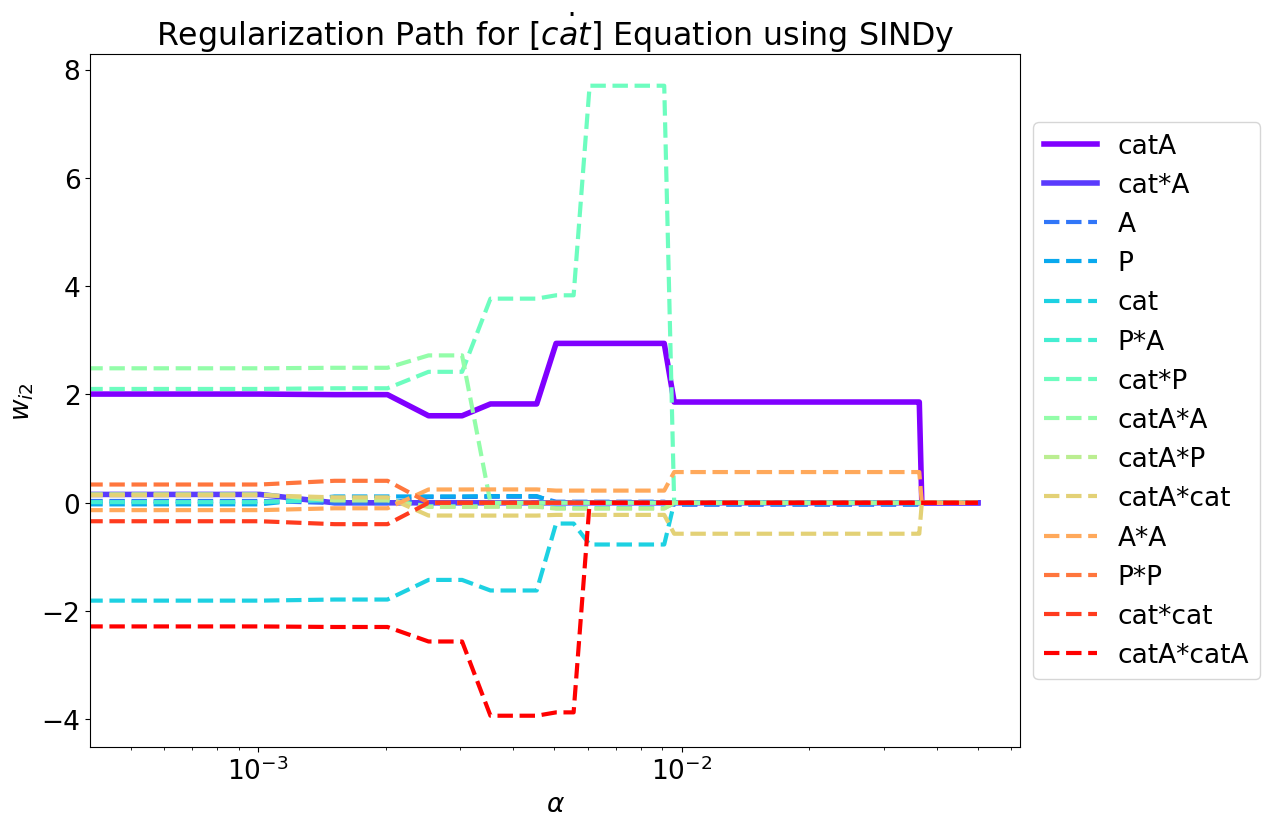

In [40]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ Equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ Equation using SINDy')

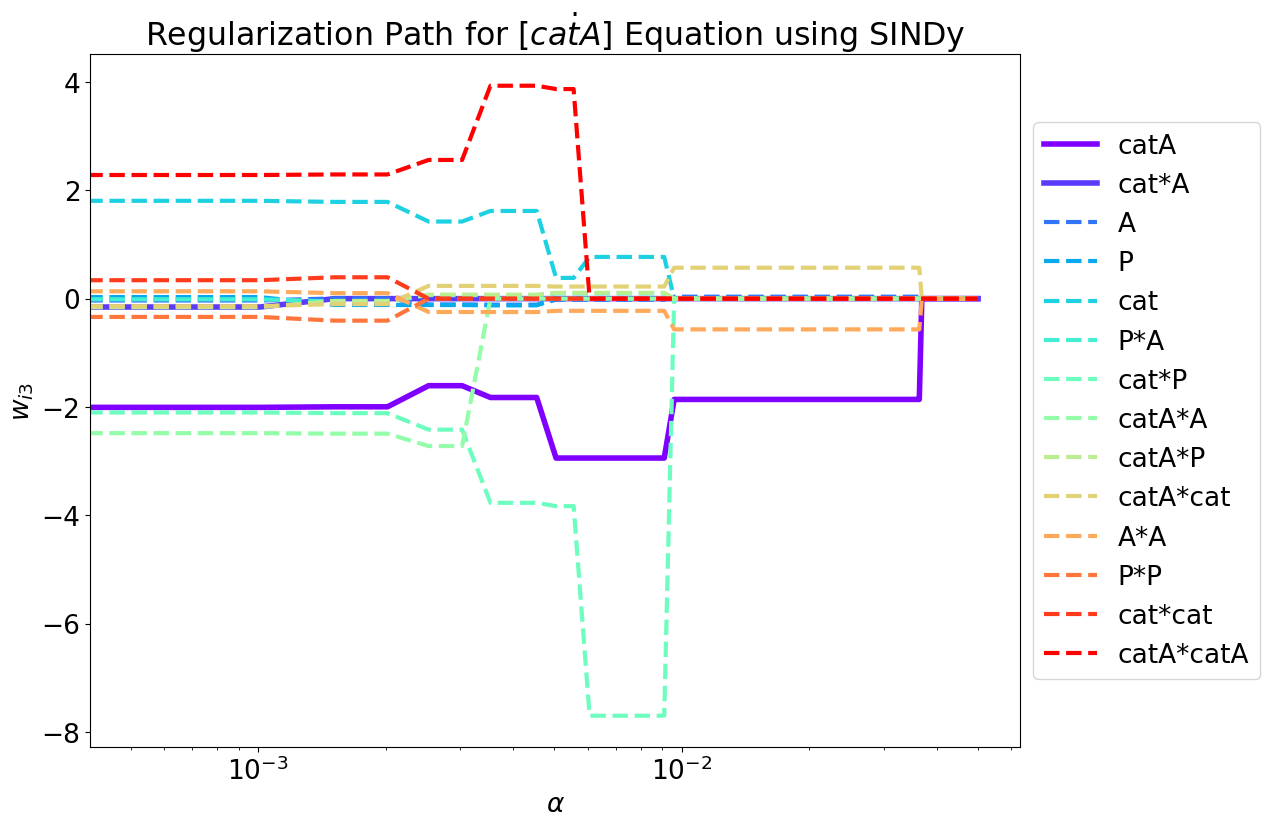

In [41]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ Equation using SINDy")

In [42]:
W_sindy_arr = []
alphas = np.linspace(0, 0.2, 200)
W_ridge_arr = []
for alph in alphas: 
    opt = ps.STLSQ(threshold = 0.015, alpha=alph) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

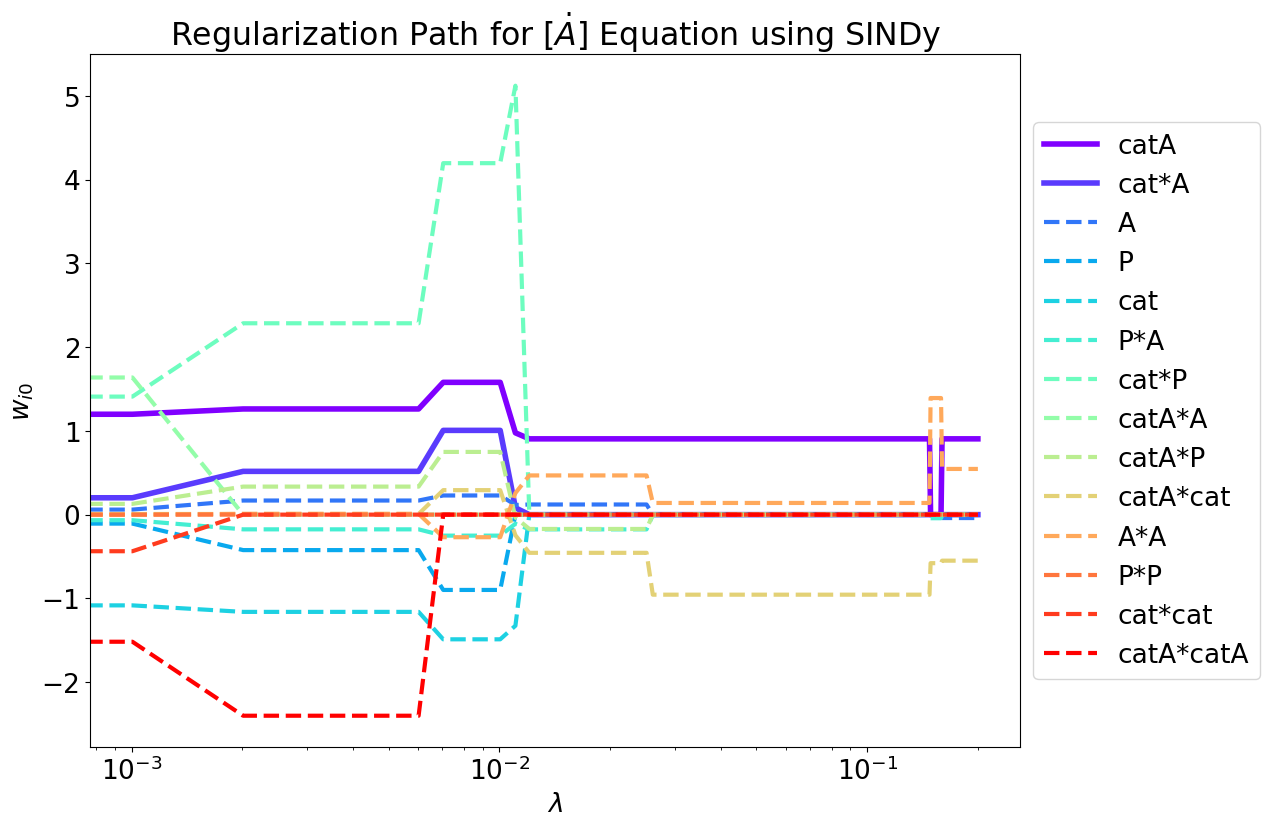

In [43]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

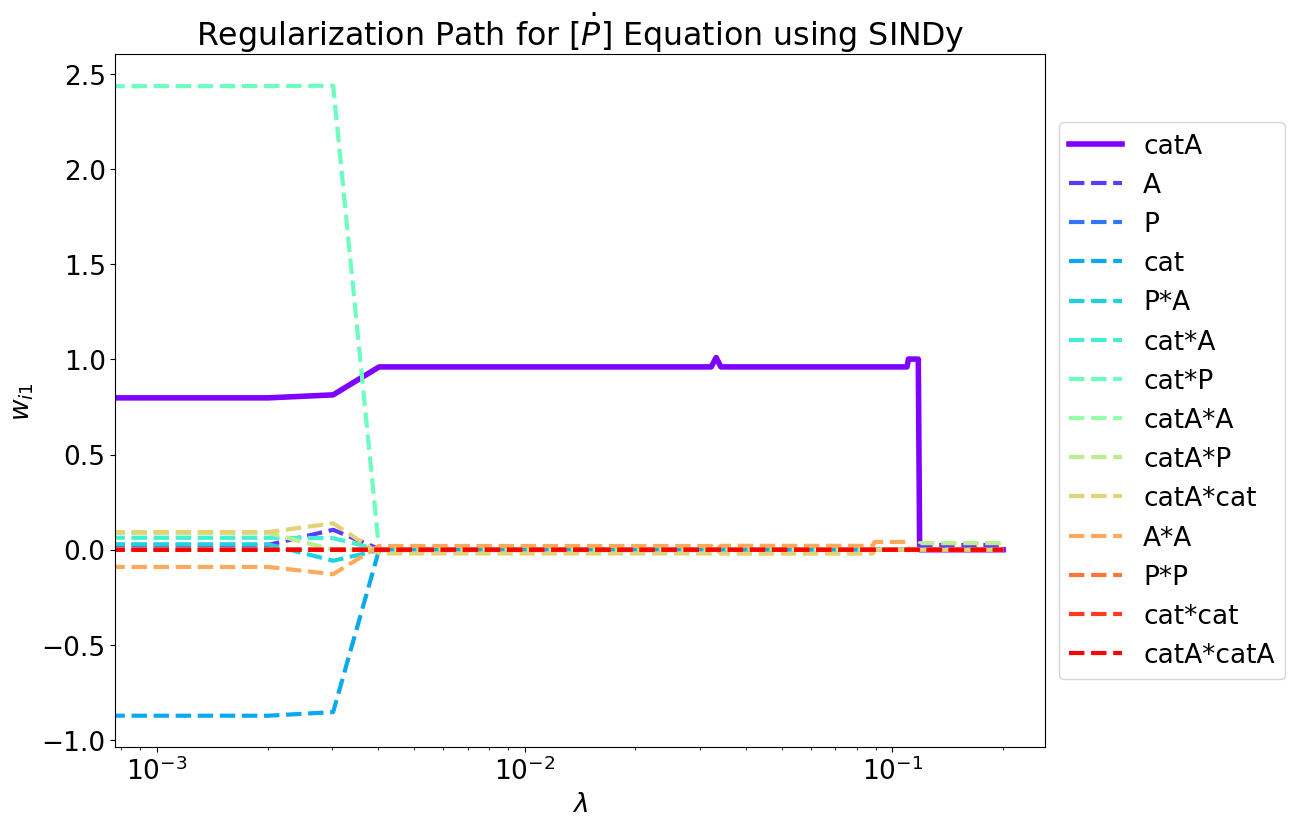

In [44]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

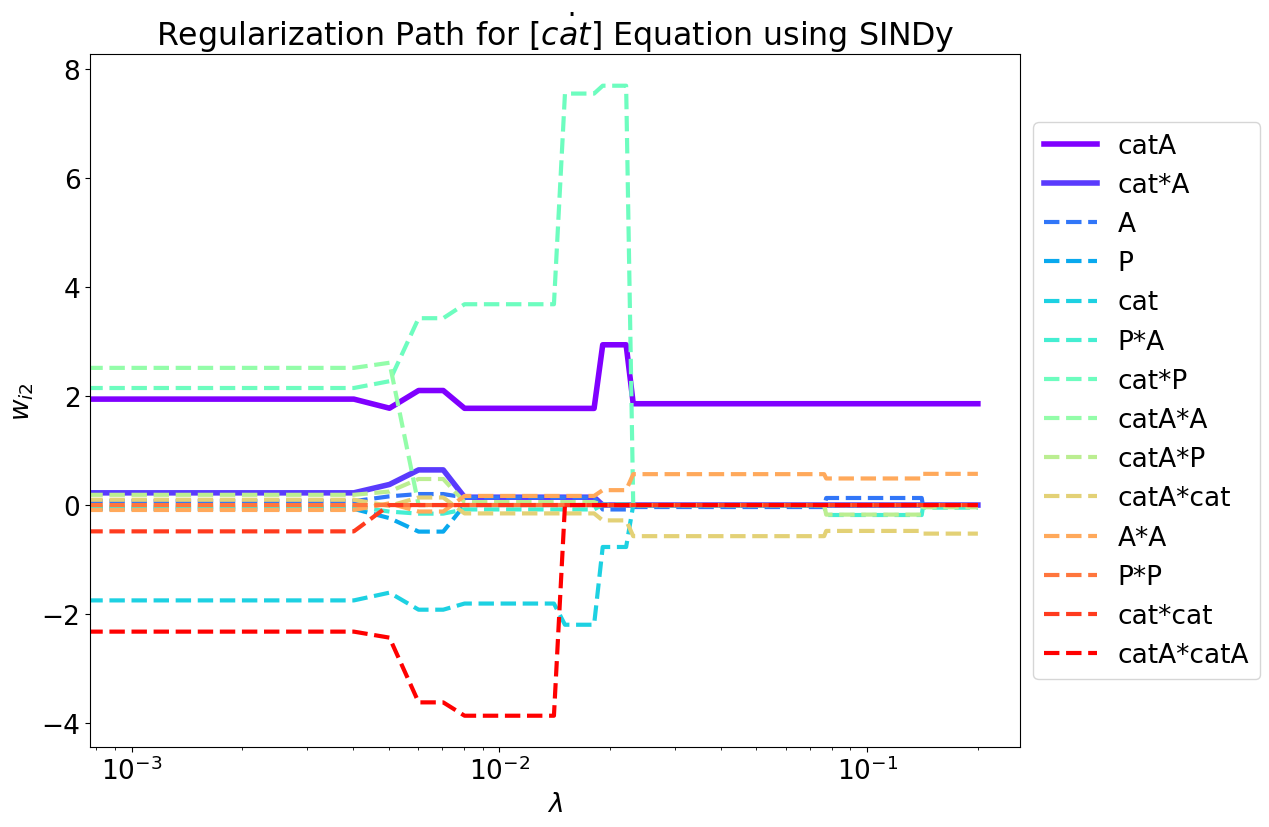

In [45]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

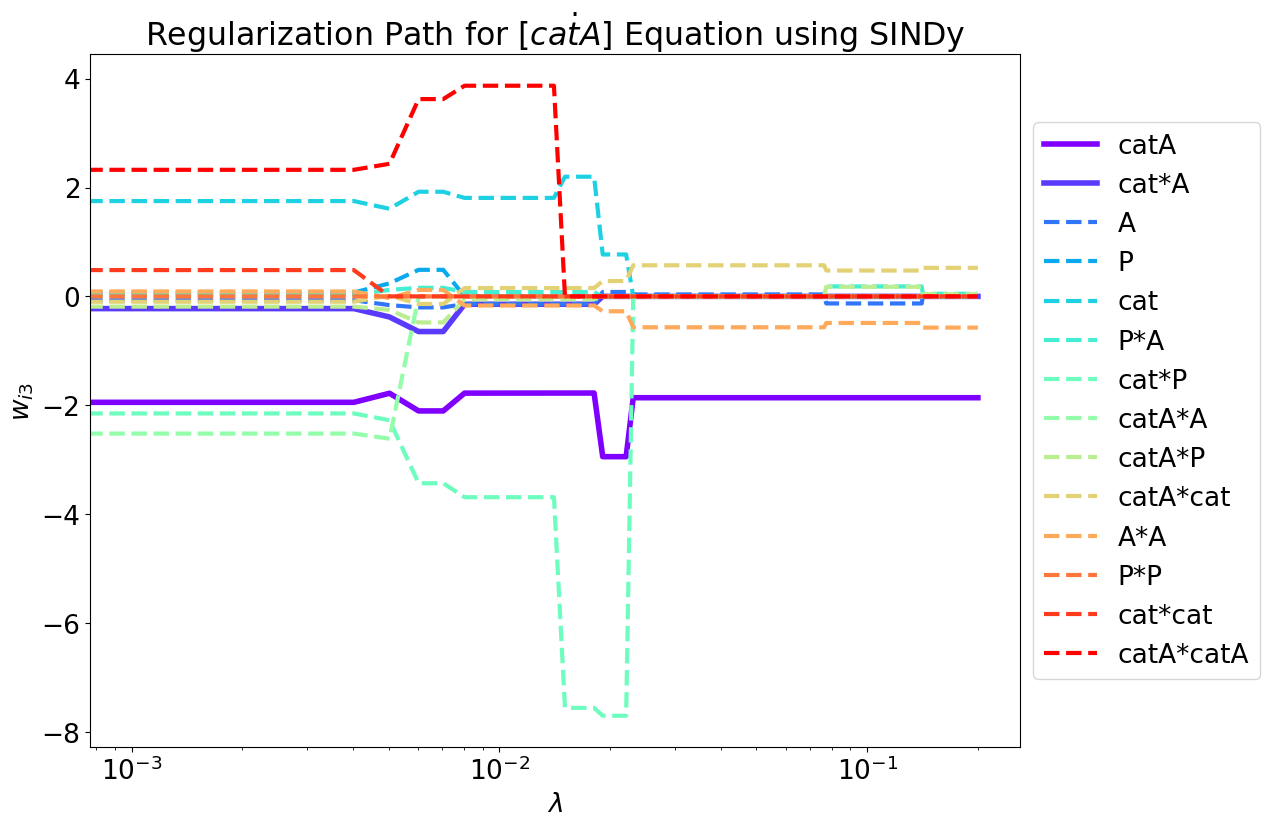

In [46]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ Equation using SINDy")
plt.xlabel('$\lambda$')

In [60]:
lambd = 0.01 
alpha = 0.05

In [61]:
opt = ps.STLSQ(threshold = alpha, alpha=lambd) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()

(A)' = 1.006 catA + -1.005 A*cat
(P)' = 1.009 catA + -0.002 A*cat + -0.008 A*catA
(cat)' = 2.025 catA + -1.006 A*cat + -0.025 A*catA
(catA)' = -2.025 catA + 1.006 A*cat + 0.025 A*catA


In [64]:
mechanisms.print_equation(labels, W_sindy, rtol)

+1.01[catA]-1.00[catA*cat]
______
+1.01[catA]-0.00[catA*cat]-0.01[A*A]
______
+2.03[catA]-1.01[catA*cat]-0.02[A*A]
______
-2.03[catA]+1.01[catA*cat]+0.02[A*A]
______
sparsity: 11


11

In [65]:
_, er_w = mechanisms.get_residual(W_sindy, W0)

absolute residual 2.4573437022382594
relative residual 0.6745992317238062


In [66]:
s = mechanisms.print_equation(labels, W_sindy, 1e-6)

+1.01[catA]-1.00[catA*cat]
______
+1.01[catA]-0.00[catA*cat]-0.01[A*A]
______
+2.03[catA]-1.01[catA*cat]-0.02[A*A]
______
-2.03[catA]+1.01[catA*cat]+0.02[A*A]
______
sparsity: 11


In [76]:
table = pd.DataFrame({'$\lambda$': [lambd],  '$\alpha$': [alpha], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]})
table

,$\lambda$,$lpha$,$\epsilon_r(\hat{W})$,s
0,0.01,0.05,0.674599,11


In [83]:
lambd = 0.1 
alpha = 0.01

In [84]:
opt = ps.STLSQ(threshold = alpha, alpha=lambd) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()

(A)' = -0.041 A + 0.905 catA + -0.005 A*A + -0.550 A*cat + 0.546 A*catA
(P)' = 0.002 A + 0.961 catA + 0.002 A*P + -0.021 A*cat + 0.021 A*catA
(cat)' = 0.130 A + 1.861 catA + -0.183 A*A + -0.176 A*P + -0.475 A*cat + 0.488 A*catA
(catA)' = -0.130 A + -1.861 catA + 0.183 A*A + 0.176 A*P + 0.475 A*cat + -0.488 A*catA


In [85]:
s = mechanisms.print_equation(labels, W_sindy, 1e-6)

-0.04[A]+0.00[cat]+0.90[catA]-0.00[P*A]-0.55[catA*cat]+0.55[A*A]
______
+0.00[A]+0.96[catA]+0.00[catA*P]-0.02[catA*cat]+0.02[A*A]
______
+0.13[A]+0.00[cat]+1.86[catA]-0.18[P*A]-0.18[catA*P]-0.48[catA*cat]+0.49[A*A]
______
-0.13[A]-0.00[cat]-1.86[catA]+0.18[P*A]+0.18[catA*P]+0.48[catA*cat]-0.49[A*A]
______
sparsity: 25


In [88]:
row = pd.DataFrame({'$\lambda$': [lambd],  '$\alpha$': [alpha], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]})
table = table.append(row)
table

,$\lambda$,$lpha$,$\epsilon_r(\hat{W})$,s
0,0.01,0.05,0.674599,11
0,0.10,0.01,0.674599,25


In [90]:
lambd = 0.01 
alpha = 0.1

In [92]:
opt = ps.STLSQ(threshold = alpha, alpha=lambd) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()
s = mechanisms.print_equation(labels, W_sindy, 1e-6)

(A)' = 1.006 catA + -1.005 A*cat
(P)' = 1.005 catA + -0.010 A*catA
(cat)' = 2.025 catA + -1.006 A*cat + -0.025 A*catA
(catA)' = -2.025 catA + 1.006 A*cat + 0.025 A*catA
+1.01[catA]-1.00[catA*cat]
______
+1.01[catA]-0.01[A*A]
______
+2.03[catA]-1.01[catA*cat]-0.02[A*A]
______
-2.03[catA]+1.01[catA*cat]+0.02[A*A]
______
sparsity: 10


In [93]:
row = pd.DataFrame({'$\lambda$': [lambd],  '$\alpha$': [alpha], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]})
table = table.append(row)
table

,$\lambda$,$lpha$,$\epsilon_r(\hat{W})$,s
0,0.01,0.05,0.674599,11
0,0.10,0.01,0.674599,25
0,0.01,0.10,0.674599,10


In [94]:
lambd = 0.05 
alpha = 0.01

In [95]:
opt = ps.STLSQ(threshold = alpha, alpha=lambd) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()
s = mechanisms.print_equation(labels, W_sindy, 1e-6)

(A)' = 0.905 catA + -0.005 A*A + -0.956 A*cat + 0.139 A*catA
(P)' = 0.009 A + 0.956 catA + -0.007 A*A + -0.005 A*P + -0.019 A*cat + 0.020 A*catA
(cat)' = -0.036 A + 1.861 catA + -0.007 A*A + -0.571 A*cat + 0.568 A*catA
(catA)' = 0.036 A + -1.861 catA + 0.007 A*A + 0.571 A*cat + -0.568 A*catA
+0.00[cat]+0.90[catA]-0.00[P*A]-0.96[catA*cat]+0.14[A*A]
______
+0.01[A]+0.00[cat]+0.96[catA]-0.01[P*A]-0.00[catA*P]-0.02[catA*cat]+0.02[A*A]
______
-0.04[A]+0.00[cat]+1.86[catA]-0.01[P*A]-0.57[catA*cat]+0.57[A*A]
______
+0.04[A]-0.00[cat]-1.86[catA]+0.01[P*A]+0.57[catA*cat]-0.57[A*A]
______
sparsity: 24


In [96]:
row = pd.DataFrame({'$\lambda$': [lambd],  '$\alpha$': [alpha], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]})
table = table.append(row)
table

,$\lambda$,$lpha$,$\epsilon_r(\hat{W})$,s
0,0.01,0.05,0.674599,11
0,0.10,0.01,0.674599,25
0,0.01,0.10,0.674599,10
0,0.05,0.01,0.674599,24


In [100]:
lambd = 0.1
alpha = 0.1

In [101]:
opt = ps.STLSQ(threshold = alpha, alpha=lambd) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()
s = mechanisms.print_equation(labels, W_sindy, 1e-6)

(A)' = 0.000
(P)' = 0.000
(cat)' = 0.000
(catA)' = 0.000

______

______

______

______
sparsity: 0


/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  "coefficients".format(self.threshold)


In [102]:
row = pd.DataFrame({'$\lambda$': [lambd],  '$\alpha$': [alpha], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]})
table = table.append(row)
table

,$\lambda$,$lpha$,$\epsilon_r(\hat{W})$,s
0,0.010,0.05,0.674599,11
0,0.100,0.01,0.674599,25
0,0.010,0.10,0.674599,10
0,0.050,0.01,0.674599,24
0,0.005,0.01,0.674599,49
0,0.100,0.10,0.674599,0
